In [1]:
suppressMessages({
  options(stringsAsFactors = FALSE)
  library(Seurat)
  library(ggsci)
  library(ggplot2)
  library(dplyr)
  library(Matrix)
  library(pheatmap)
  library(ggpubr)
  library(scatterplot3d)
  library(plotly)
  library(RColorBrewer)
  library(scales)
  library(readr)
  library(reshape2)
  library(tidyr)
  library(ggpubr)
  library(viridis)
  library(mltools)
  library(data.table)
  library(ggrepel)
})

In [ ]:
mytheme <- ggplot2::theme(
  plot.background = element_blank(),
  panel.background = element_rect(fill = "#FFFFFF"),
  legend.background = element_blank(),
  legend.box.background = element_blank(),
  panel.border = element_rect(linetype = "solid", colour = "black", fill = NA, size = 0.5),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  axis.line = element_blank()
)

color <- c(c(pal_d3("category20")(20), "#B52D73", "#4347B5", "#4FED28", "#402727", "#48959C", "#FC6262", "#4A9EFF", "#9E969E"))
# specify colors
# tissue_color <- c("#33a02c","#e31a1c") #"#1f78b4",
celltype1_color <- c("#0072B5FF", "#D62728FF") # c(pal_nejm("default")(8)[c(2,1)])
celltype2_color <- c("#9467BDFF", "#FF95A8FF", "#8AA600", "#46732EFF", "#197EC0FF", "#D62728FF")
celltype3_color <- c("#9467BDFF", "#FF95A8FF", "#8AA600", "#46732EFF", "#197EC0FF", "#D62728FF", "#ff7f00", "#ffff33", "#8A9197FF")
celltype4_color <- c("#20854EFF", "#008EA0FF", "#FF6F00FF", "#C71000FF")

# Deviation matrix of UTR length: (M · (C · l)) / (M · C)


In [2]:
# M is a binary mapping matrix (0/1) with genes as rows and isoforms as columns.
# C is the isoform count matrix with isoforms as rows and cells as columns.
# l is a column vector of UTR lengths for each isoform.

In [4]:
ont <- readRDS(file = "../../CRC_HTCRC_02_RNA_seurat/CRC_HTCRC_01_RNA_5400_3262_tx/00_tx_5400_3262_hvg1869_PC1_20.rds")

## l

In [ ]:
utr <- read.table(file = "../CorrectUTR_CRC_HTCRC_01_UTR_length/UTR_info.txt", header = F, sep = "\t")
colnames(utr) <- c("chrom", "utr", "start", "end", "strand", "TranName", "GeneName")
utr$length <- abs(utr$end - utr$start)
utr$utr_coor <- paste(utr$start, utr$end, sep = "_")

utr3 <- utr %>%
  filter(utr %in% "three_prime_utr") %>%
  group_by(TranName) %>%
  # cat all UTR from the same isoform
  mutate(UTR3ID = paste(
    GeneName, chrom, paste(utr_coor, collapse = "__"),
    sep = "-"
  ), UTR3_length = sum(length)) %>%
  dplyr::select(TranName, UTR3ID, GeneName, UTR3_length) %>%
  as.data.frame() %>%
  filter(!duplicated(TranName)) %>%
  `rownames<-`(.$TranName) %>%
  arrange(TranName) %>%
  group_by(GeneName) %>%
  mutate(UTR3_number = length(unique(UTR3ID))) %>%
  as.data.frame()
dim(utr3)
head(utr3, 2)

In [6]:
write.table(utr3, file = "0_3UTR_info_21026.txt", sep = "\t", quote = F, row.names = F)

In [7]:
utr3ID_gene <- utr3 %>%
  dplyr::select(UTR3ID, GeneName, UTR3_length, UTR3_number) %>%
  filter(!duplicated(UTR3ID))
dim(utr3ID_gene)

[1] 19568     4

In [8]:
write.table(utr3ID_gene, file = "0_3UTR_info_UTR3ID_19568.txt", sep = "\t", quote = F, row.names = F)


   1    2    3    4    5    6    7    8    9   10   12 
6018 3079 1275  484  172   73   30    7    5    1    1 

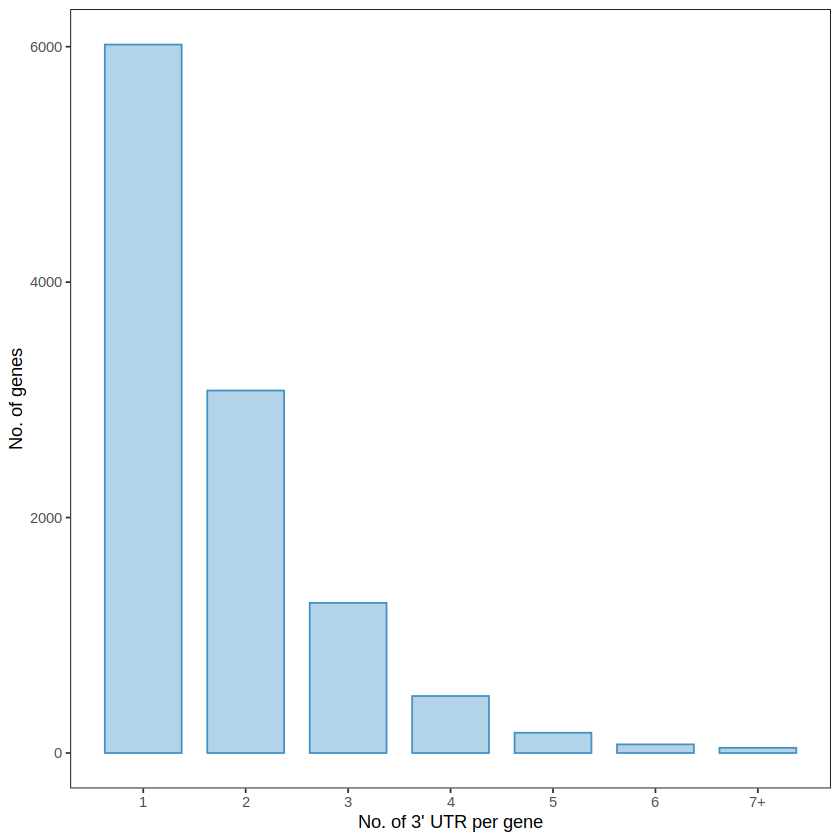

In [9]:
utr3_freq <- as.data.frame(table(utr3ID_gene$GeneName))
table(utr3_freq$Freq)
length(utr3_freq$Var1)

mybin <- 7
df_p <- utr3_freq
df_p[which(df_p$Freq >= 7), ]$Freq <- 7
ggplot(df_p, aes(x = Freq)) +
  geom_bar(fill = "#4292c6", alpha = 0.4, color = "#4292c6", width = 0.75) +
  mytheme + # xlim(0,10)+
  scale_x_continuous(breaks = seq(1, mybin, 1), labels = c("1", "2", "3", "4", "5", "6", "7+")) +
  labs(x = "No. of 3' UTR per gene", y = "No. of genes")
ggsave(file = "0_UTR3_per_gene_histogram.pdf", height = 2.5, width = 3)

In [10]:
gene_gt_1UTR <- as.character(utr3_freq[which(utr3_freq$Freq >= 2), ]$Var1)
length(gene_gt_1UTR)

utr3ID_gene <- utr3ID_gene[which(utr3ID_gene$GeneName %in% gene_gt_1UTR), ]
dim(utr3ID_gene)

[1] 5127

[1] 13550     4

In [11]:
write.table(utr3ID_gene, file = "0_3UTR_info_UTR3ID_gt1utr_13550.txt", sep = "\t", quote = F, row.names = F)

## M

In [12]:
utr3ID_gene$GeneName <- factor(utr3ID_gene$GeneName)
utr3ID_gene_onehot <- mltools::one_hot(as.data.table(utr3ID_gene[, c("UTR3ID", "GeneName")]))
utr3ID_gene_onehot <- utr3ID_gene_onehot %>%
  as.data.frame() %>%
  `rownames<-`(.$UTR3ID) %>%
  dplyr::select(-UTR3ID) %>%
  `colnames<-`(gsub("GeneName_", "", colnames(.))) %>%
  t() %>%
  as.matrix()
dim(utr3ID_gene_onehot)
head(utr3ID_gene_onehot, 2)

[1]  5127 13550

,A1CF-10-50806562_50806728,A1CF-10-50799409_50806728,A1CF-10-50799409_50806880__50809894_50810042__50811040_50811176__50813857_50814062__50816006_50816279__50820552_50820649__50828131_50828295__50836074_50836312__50841862_50841992__50843988_50844122__50859842_50859940,AAAS-12-53307460_53307488,AAAS-12-53307459_53307488,AAAS-12-53307456_53307489,AAAS-12-53307448_53307713__53307845_53308042,AAAS-12-53307448_53308133__53308282_53308349__53308435_53308528__53308725_53308815__53308960_53309020__53309157_53309281__53309601_53309721__53314298_53314441__53314751_53314849__53315094_53315140__53315335_53315426__53315727_53315782__53320565_53320692__53321343_53321465,AAAS-12-53307448_53307713__53308052_53308133__53308282_53308349__53308435_53308528__53308725_53308815__53308960_53309020__53309157_53309281__53309601_53309721__53314298_53314441__53314751_53314849__53315094_53315140__53315335_53315426__53315727_53315782__53320565_53320692__53321343_53321465,AAGAB-15-67200667_67202820,⋯,ZWILCH-15-66546680_66546705__66548351_66549487,ZWILCH-15-66546680_66546705__66548351_66548426,ZWINT-10-56357227_56358185__56358377_56358417,ZWINT-10-56357438_56358417,ZXDC-3-126461083_126461528,ZXDC-3-126437601_126438374,ZZZ3-1-77562416_77565639,ZZZ3-1-77564504_77565784__77566081_77566181__77568332_77568466__77576068_77576220__77578774_77578869__77579527_77579628__77580998_77581069__77581776_77581891__77581979_77582126__77584517_77584655__77631850_77633354,ZZZ3-1-77564504_77565784__77566081_77566181__77568332_77568466__77576068_77576220__77578774_77578869__77579527_77579628__77580998_77581069__77581776_77581888__77581979_77582126__77584517_77584655__77631850_77633354,ZZZ3-1-77564504_77565784__77566081_77566181__77568332_77568466__77576068_77576220__77578774_77578869__77579527_77579628__77580998_77581069__77581776_77581823
A1CF,1,1,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AAAS,0,0,0,1,1,1,1,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0


## C

In [13]:
df_tpm <- read.csv(file = "../../CRC_HTCRC_01_RNA_QC/00_tx_tpm_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)
tpm_utr3 <- df_tpm[utr3$TranName, ]
tpm_utr3$UTR3ID <- utr3$UTR3ID
tpm_utr3 <- tpm_utr3 %>%
  group_by(UTR3ID) %>%
  summarise_all(sum) %>%
  as.data.frame() %>%
  `rownames<-`(.$UTR3ID)
tpm_utr3$UTR3ID <- NULL
tpm_utr3 <- tpm_utr3[utr3ID_gene$UTR3ID, ]
dim(tpm_utr3)
head(tpm_utr3, 2)

[1] 13550  3262

,CRC01_L1_Barcode01,CRC01_L1_Barcode02,CRC01_L1_Barcode03,CRC01_L1_Barcode04,CRC01_L1_Barcode05,CRC01_L1_Barcode08,CRC01_L1_Barcode09,CRC01_L1_Barcode10,CRC01_L1_Barcode11,CRC01_L1_Barcode12,⋯,HTCRC05_PT2_Bc96_Bc34,HTCRC05_PT2_Bc96_Bc35,HTCRC05_PT2_Bc96_Bc37,HTCRC05_PT2_Bc96_Bc38,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1CF-10-50806562_50806728,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A1CF-10-50799409_50806728,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [15]:
length(utr3ID_gene$UTR3ID)

[1] 13550

In [16]:
write.table(tpm_utr3, file = "0_3UTR_tpm_UTR3ID_gt1utr_13550.txt", sep = "\t", quote = F, row.names = F)

## Use Fisher’s exact test to identify UTRs with significant variation within each gene

In [17]:
ne_cells <- ont@meta.data[which(ont@meta.data$celltype1 %in% "Normal epithelium"), ]$CellName
cc_cells <- ont@meta.data[which(ont@meta.data$celltype1 %in% "Cancer cells"), ]$CellName

In [18]:
utr3ID_gene$NE <- round(rowMeans(tpm_utr3[utr3ID_gene$UTR3ID, ne_cells]), 3)
utr3ID_gene$CC <- round(rowMeans(tpm_utr3[utr3ID_gene$UTR3ID, cc_cells]), 3)

In [19]:
head(utr3ID_gene, 2)

,UTR3ID,GeneName,UTR3_length,UTR3_number,NE,CC
,<chr>,<fct>,<int>,<int>,<dbl>,<dbl>
1,A1CF-10-50806562_50806728,A1CF,166,3,1.052,1.502
2,A1CF-10-50799409_50806728,A1CF,7319,3,10.552,1.274


In [20]:
write.table(utr3ID_gene, file = "0_3UTR_info_UTR3ID_gt1utr_13550.txt", sep = "\t", quote = F, row.names = F)

In [24]:
set.seed(0)
alt_utr3 <- utr3ID_gene %>%
  mutate(NE = round(NE), CC = round(CC)) %>%
  filter(NE != 0 | CC != 0) %>%
  group_by(GeneName) %>%
  filter(n() >= 2) %>%
  filter(sum(NE > 0) > 0 & sum(CC > 0) > 0) %>%
  summarise(fisher_pvalue = fisher.test(round(cbind(NE, CC)), simulate.p.value = TRUE)$p.value) %>%
  mutate(fisher_fdr = p.adjust(fisher_pvalue, method = "fdr"))

In [ ]:
dim(alt_utr3)
dim(alt_utr3 %>% filter(fisher_pvalue < 0.05))
dim(alt_utr3 %>% filter(fisher_fdr < 0.05))

In [26]:
write.table(alt_utr3, file = "0_UTR3_FisherTest_NE_CC_4699genes.txt", sep = "\t", quote = F, row.names = F)

## (Mapping·(Counts·length) / (Mapping·Counts))

In [5]:
# (Mapping·(Counts·length) / (Mapping·Counts)) represents the average expressed UTR length of each gene

In [27]:
matrix_utr <- function(mapping, counts, len) {
  counts <- as.matrix(counts)
  mapping <- mapping[, rownames(counts)]
  numerator <- mapping %*% (counts * as.numeric(as.matrix(len)))
  denominator <- mapping %*% counts
  weighted_len <- as.data.frame(numerator / denominator)
  rownames(weighted_len) <- rownames(mapping)
  colnames(weighted_len) <- colnames(counts)

  return(weighted_len)
}

In [28]:
df_utr3 <- matrix_utr(utr3ID_gene_onehot, tpm_utr3[utr3ID_gene$UTR3ID, ], utr3ID_gene[, c("UTR3_length"), drop = F])
dim(df_utr3)
head(df_utr3, 1)

[1] 5127 3262

,CRC01_L1_Barcode01,CRC01_L1_Barcode02,CRC01_L1_Barcode03,CRC01_L1_Barcode04,CRC01_L1_Barcode05,CRC01_L1_Barcode08,CRC01_L1_Barcode09,CRC01_L1_Barcode10,CRC01_L1_Barcode11,CRC01_L1_Barcode12,⋯,HTCRC05_PT2_Bc96_Bc34,HTCRC05_PT2_Bc96_Bc35,HTCRC05_PT2_Bc96_Bc37,HTCRC05_PT2_Bc96_Bc38,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1CF,9094,NaN,9094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,9094,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
ne_cells <- ont@meta.data[which(ont@meta.data$celltype1 %in% "Normal epithelium"), ]$CellName
df_utr3_deviation <- df_utr3 - rowMeans(df_utr3[, ne_cells], na.rm = T)
dim(df_utr3_deviation)
df_utr3_deviation <- df_utr3_deviation[!rowSums(is.na(df_utr3_deviation)) == ncol(df_utr3_deviation), ]
dim(df_utr3_deviation)
head(df_utr3_deviation, 1)

[1] 5127 3262

[1] 5126 3262

,CRC01_L1_Barcode01,CRC01_L1_Barcode02,CRC01_L1_Barcode03,CRC01_L1_Barcode04,CRC01_L1_Barcode05,CRC01_L1_Barcode08,CRC01_L1_Barcode09,CRC01_L1_Barcode10,CRC01_L1_Barcode11,CRC01_L1_Barcode12,⋯,HTCRC05_PT2_Bc96_Bc34,HTCRC05_PT2_Bc96_Bc35,HTCRC05_PT2_Bc96_Bc37,HTCRC05_PT2_Bc96_Bc38,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1CF,627.0318,NaN,627.0318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,627.0318,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_utr3_deviation <- df_utr3_deviation[-which(rowSums(abs(df_utr3_deviation), na.rm = T) < 10), ]
dim(df_utr3_deviation)

[1] 5069 3262

In [31]:
write.table(df_utr3_deviation, file = "0_3UTR_deviation_gene_5069.txt", sep = "\t", quote = F, row.names = T)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-149.19  -47.33  -18.83  -17.99   10.03  117.12 

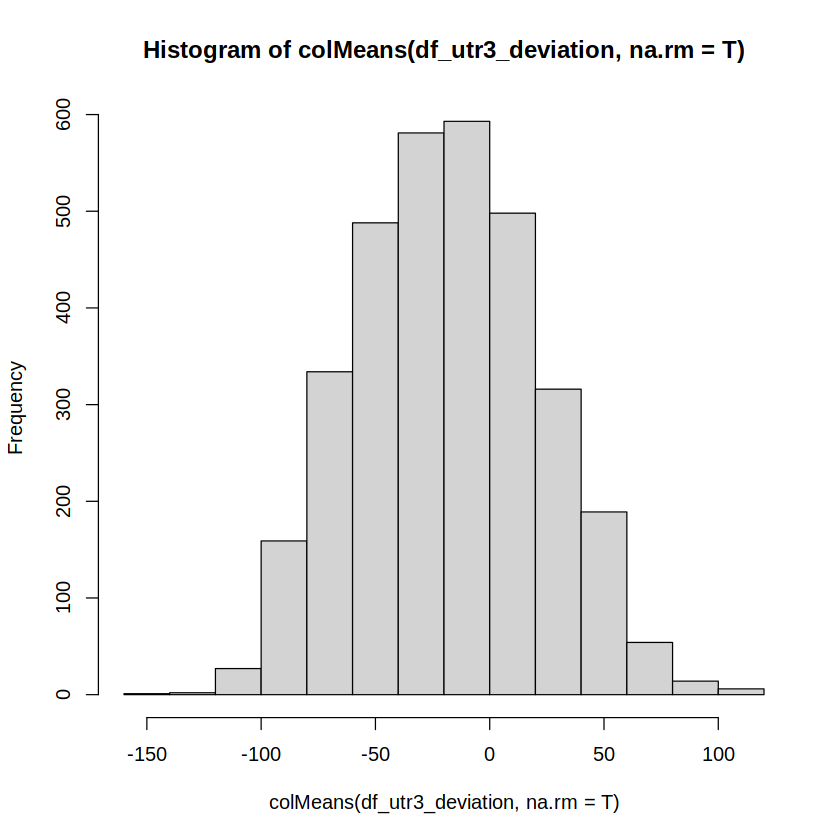

In [32]:
summary(colMeans(df_utr3_deviation, na.rm = T))
hist(colMeans(df_utr3_deviation, na.rm = T))

## add UTR assay

In [33]:
df_utr3_deviation_AllGene <- df_utr3_deviation
df_utr3_deviation_AllGene["AllGene", ] <- colMeans(df_utr3_deviation_AllGene, na.rm = T)

# add this assay to the previously created Seurat object
ont[["UTR3"]] <- CreateAssayObject(counts = df_utr3_deviation_AllGene)
DefaultAssay(ont) <- "UTR3"

In [34]:
ne_cells <- ont@meta.data[which(ont@meta.data$celltype1 %in% "Normal epithelium"), ]$CellName
cc_cells <- ont@meta.data[which(ont@meta.data$celltype1 %in% "Cancer cells"), ]$CellName
summary(as.numeric(df_utr3_deviation_AllGene["AllGene", ne_cells]), na.rm = T)
summary(as.numeric(df_utr3_deviation_AllGene["AllGene", cc_cells]), na.rm = T)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-78.430 -14.608   9.268   9.497  33.318 117.115 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-149.188  -54.497  -28.324  -26.898   -1.124  102.638 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Saving 6.67 x 3.5 in image


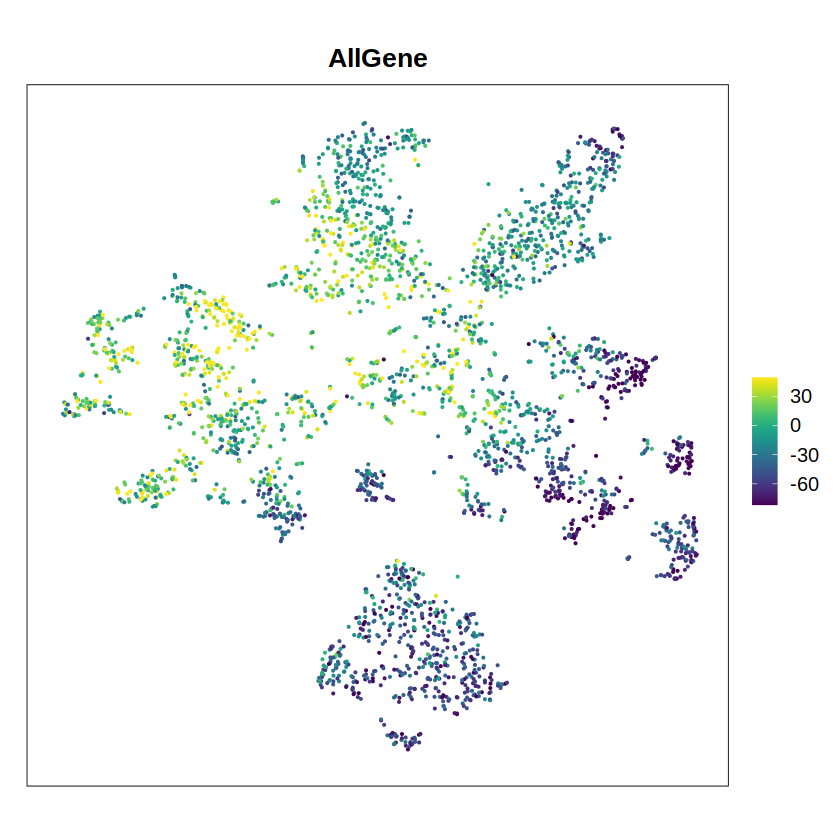

In [35]:
FeaturePlot(ont,
  reduction = "tsne", features = c("AllGene"), slot = "counts",
  min.cutoff = quantile(colMeans(df_utr3_deviation, na.rm = T), 0.05),
  max.cutoff = quantile(colMeans(df_utr3_deviation, na.rm = T), 0.95)
) + # scale_color_viridis_c(option = "plasma")
  scale_color_viridis(breaks = c(-60, -30, 0, 30)) + featureplot_theme #+ scale_color_continuous(breaks = c(-80, -40, 0, 40))
ggsave("1_featureplot_3UTR_deviation.pdf", height = 3.5)

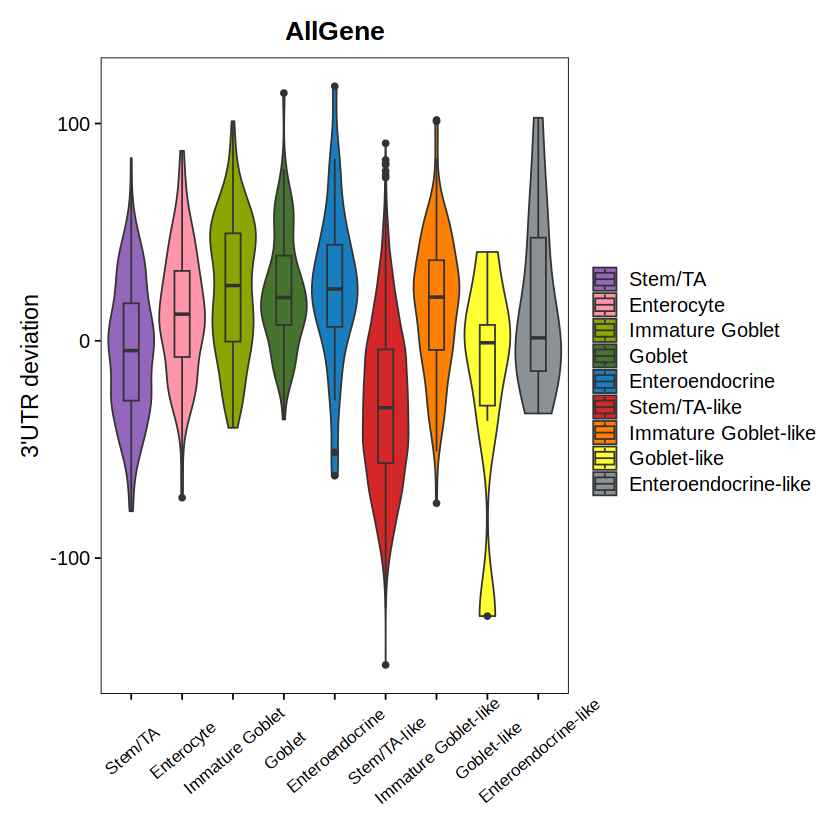

In [36]:
VlnPlot(ont, features = "AllGene", group.by = "celltype3", pt.size = 0, slot = "counts") +
  geom_boxplot(width = 0.3) +
  scale_fill_manual(values = alpha(celltype3_color, 1)) +
  mytheme + ylab("3'UTR deviation") +
  theme(axis.text.x = element_text(angle = 40, size = 10, vjust = 0.6, hjust = 0.5), axis.title.x = element_blank())
ggsave("1_vlnplot_3UTR_deviation_all.pdf", height = 4, width = 9)

In [11]:
ont <- readRDS(file = "../../CRC_HTCRC_02_RNA_seurat/CRC_HTCRC_01_RNA_5400_3262_tx/00_tx_5400_3262_hvg1869_PC1_20.rds")

In [37]:
saveRDS(ont, file = "../../CRC_HTCRC_02_RNA_seurat/CRC_HTCRC_01_RNA_5400_3262_tx/00_tx_5400_3262_hvg1869_PC1_20.rds")

# Differential 3'-UTR deviation

In [38]:
# ne_cells <- ont@meta.data[which(ont@meta.data$celltype1 %in% 'Normal epithelium'),]$CellName
# cc_cells <- ont@meta.data[which(ont@meta.data$celltype1 %in% 'Cancer cells'),]$CellName
ne_cells <- ont@meta.data[which(ont@meta.data$celltype3 %in% "Stem/TA"), ]$CellName
length(ne_cells)
cc_cells <- ont@meta.data[which(ont@meta.data$celltype3 %in% "Stem/TA-like"), ]$CellName
length(cc_cells)

[1] 359

[1] 2320

In [39]:
ont_sub <- subset(ont, cells = c(ne_cells, cc_cells))
ont_sub

An object of class Seurat 
52179 features across 2679 samples within 4 assays 
Active assay: UTR3 (5070 features, 0 variable features)
 3 other assays present: RNA, GENE, UTR5
 3 dimensional reductions calculated: pca, tsne, umap

In [40]:
table(ont_sub@meta.data$celltype1)


Normal epithelium      Cancer cells 
              359              2320 

In [44]:
df_utr3_deviation <- read.table(file = "0_3UTR_deviation_gene_5069.txt", sep = "\t", header = T, row.names = 1)
df_utr3_deviation <- df_utr3_deviation[, c(ne_cells, cc_cells)]
df_utr3_deviation <- df_utr3_deviation[
  -which(rowSums(is.na(df_utr3_deviation[, (ont_sub@meta.data %>% filter(data %in% "HTCRC"))$CellName])) == length((ont_sub@meta.data %>% filter(data %in% "HTCRC"))$CellName)),
]
df_utr3_deviation <- df_utr3_deviation[
  -which(rowSums(is.na(df_utr3_deviation[, (ont_sub@meta.data %>% filter(celltype1 %in% "Normal epithelium"))$CellName])) == length((ont_sub@meta.data %>% filter(celltype1 %in% "Normal epithelium"))$CellName)),
]
dim(df_utr3_deviation)
head(df_utr3_deviation, 1)

[1] 5062 2679

,CRC01_L1_Barcode01,CRC01_L1_Barcode08,CRC01_L1_Barcode09,CRC01_L1_Barcode10,CRC01_L1_Barcode17,CRC01_L1_Barcode21,CRC01_L1_Barcode22,CRC01_L1_Barcode30,CRC01_L1_Barcode33,CRC01_L1_Barcode34,⋯,HTCRC05_PT2_Bc96_Bc32,HTCRC05_PT2_Bc96_Bc35,HTCRC05_PT2_Bc96_Bc37,HTCRC05_PT2_Bc96_Bc38,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1CF,627.0318,NA,NA,NA,NA,NA,NA,-1146.832,-1147.968,NA,⋯,NA,NA,NA,627.0318,NA,NA,NA,NA,NA,NA


In [45]:
df_gene_tpm <- read.csv(file = "../../CRC_HTCRC_01_RNA_QC/00_gene_tpm_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)
df_gene_tpm <- df_gene_tpm[rownames(df_utr3_deviation), c(ne_cells, cc_cells)]

## Linear Mixed-Effects Model, LMM

In [41]:
# Formula: UTR_deviation ∼ Cell_Type + (1|Batch)
# Cell_Type is Fixed Effect
# Batch is Random Effect

In [ ]:
library(lmerTest)

In [47]:
t_df_utr3_deviation <- as.data.frame(t(df_utr3_deviation))
t_df_utr3_deviation$celltype1 <- ont@meta.data[rownames(t_df_utr3_deviation), ]$celltype1
t_df_utr3_deviation$data <- ont@meta.data[rownames(t_df_utr3_deviation), ]$data
head(t_df_utr3_deviation, 2)

,A1CF,AAAS,AAGAB,AAMDC,AAMP,AAR2,AARSD1,AASDH,AATF,ABCA2,⋯,ZSCAN32,ZSCAN5A,ZSCAN9,ZSWIM7,ZWILCH,ZWINT,ZXDC,ZZZ3,celltype1,data
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
CRC01_L1_Barcode01,627.0318,NA,26.52205,-13.42812,0.3138165,NA,NA,NA,NA,NA,⋯,NA,NA,NA,-450.4068,NA,NA,97.39383,NA,Normal epithelium,CRC
CRC01_L1_Barcode08,NA,-319.2719,NA,-11.90985,0.3138165,NA,-59.14322,-467.5616,1.205213,NA,⋯,NA,NA,0.1154183,-537.3804,NA,2.760071,NA,-1115.151,Normal epithelium,CRC


In [48]:
gene_columns <- rownames(df_utr3_deviation)

In [ ]:
results_list <- list()

for (gene in gene_columns) {
  # Dynamically build the model formula
  model_formula <- as.formula(paste("`", gene, "` ~ celltype1 + (1 | data)", sep = "")) # data is batch
  # Fit the linear mixed-effects model
  model <- lmer(model_formula, data = t_df_utr3_deviation)
  summary_model <- summary(model)
  p_values <- summary_model$coefficients[, "Pr(>|t|)"]

  gene_results <- data.frame(
    GeneName = gene,
    deviation_LMM_Estimate = summary_model$coefficients["celltype1Cancer cells", "Estimate"],
    deviation_LMM_StdError = summary_model$coefficients["celltype1Cancer cells", "Std. Error"],
    deviation_LMM_tValue = summary_model$coefficients["celltype1Cancer cells", "t value"],
    deviation_LMM_pValue = p_values["celltype1Cancer cells"],
    stringsAsFactors = FALSE
  )

  results_list[[gene]] <- gene_results
}

df_dugs <- do.call(rbind, results_list) # dugs, differential UTR genes

# Adjust p-values for FDR
df_dugs$deviation_LMM_FDR <- p.adjust(df_dugs$deviation_LMM_pValue, method = "fdr")

In [50]:
dim(df_dugs %>% filter(deviation_LMM_Estimate < 0, deviation_LMM_FDR < 0.05))

[1] 321   6

In [51]:
df_dugs$deviation_NE <- rowMeans(df_utr3_deviation[rownames(df_dugs), ne_cells], na.rm = T)
df_dugs$deviation_CC <- rowMeans(df_utr3_deviation[rownames(df_dugs), cc_cells], na.rm = T)
df_dugs$deviation_diff <- df_dugs$deviation_CC - df_dugs$deviation_NE

## Wilcox.test

In [ ]:
df_dugs <- df_dugs %>%
  filter(!is.na(deviation_diff)) %>%
  group_by(GeneName) %>%
  mutate(
    deviation_diff_wilcox_pvalue = wilcox.test(
      as.numeric(df_utr3_deviation[GeneName, cc_cells]), as.numeric(df_utr3_deviation[GeneName, ne_cells])
    )$p.value
  ) %>%
  as.data.frame()
df_dugs <- df_dugs[!is.na(df_dugs$deviation_diff_wilcox_pvalue), ]
df_dugs$deviation_diff_wilcox_fdr <- p.adjust(df_dugs$deviation_diff_wilcox_pvalue, method = "fdr")
dim(df_dugs)

## Test association between UTR deviation and gene expression using LMM

In [ ]:
gene_columns <- df_dugs$GeneName

results_list <- list()

for (gene in gene_columns) {
  df_model_exp_devi <- data.frame(
    gene_tpm = as.numeric(df_gene_tpm[gene, ]),
    devi = as.numeric(df_utr3_deviation[gene, ]),
    data = ont@meta.data[c(ne_cells, cc_cells), ]$data,
    celltype1 = ont@meta.data[c(ne_cells, cc_cells), ]$celltype1
  )
  # Fit linear mixed-effects model
  model <- lmer(gene_tpm ~ devi + celltype1 + (1 | data), data = df_model_exp_devi)
  summary_model <- summary(model)
  if ("devi" %in% rownames(summary_model$coefficients)) {
    devi_effect <- summary_model$coefficients["devi", ]

    gene_results <- data.frame(
      GeneName = gene,
      GeneTPM_Deviation_LMM_Estimate = devi_effect["Estimate"],
      GeneTPM_Deviation_LMM_StdError = devi_effect["Std. Error"],
      GeneTPM_Deviation_LMM_tValue = devi_effect["t value"],
      GeneTPM_Deviation_LMM_pValue = devi_effect["Pr(>|t|)"],
      stringsAsFactors = FALSE
    )

    results_list[[gene]] <- gene_results
  }
}

results_exp_devi <- do.call(rbind, results_list)

# FDR
results_exp_devi$GeneTPM_Deviation_LMM_FDR <- p.adjust(results_exp_devi$GeneTPM_Deviation_LMM_pValue, method = "fdr")

In [54]:
df_dugs <- merge(df_dugs, results_exp_devi, by = "GeneName")
dim(df_dugs)

[1] 5062   16

## Calculate the correlation between deviation and gene expression

In [55]:
df_dugs <- df_dugs %>%
  group_by(GeneName) %>%
  mutate(
    GeneTPM_Deviation_Cor = cor.test(
      as.numeric(df_utr3_deviation[GeneName, c(ne_cells, cc_cells)]),
      as.numeric(df_gene_tpm[GeneName, c(ne_cells, cc_cells)]),
      use = "complete.obs", method = "spearman"
    )$estimate,
    GeneTPM_Deviation_Cor_pvalue = cor.test(
      as.numeric(df_utr3_deviation[GeneName, c(ne_cells, cc_cells)]),
      as.numeric(df_gene_tpm[GeneName, c(ne_cells, cc_cells)]),
      use = "complete.obs", method = "spearman"
    )$p.value,
    gene_tpm_NE = rowMeans(df_gene_tpm[GeneName, ne_cells]),
    gene_tpm_CC = rowMeans(df_gene_tpm[GeneName, cc_cells]),
    gene_tpm_log2FoldChange = log2(rowMeans(df_gene_tpm[GeneName, cc_cells]) / rowMeans(df_gene_tpm[GeneName, ne_cells]))
  )
df_dugs$GeneTPM_Deviation_Cor_fdr <- p.adjust(df_dugs$GeneTPM_Deviation_Cor_pvalue, method = "fdr")

Warning message:
“There were 10124 warnings in `mutate()`.
The first warning was:
ℹ In argument: `GeneTPM_Deviation_Cor = `$`(...)`.
ℹ In group 1: `GeneName = "A1CF"`.
Caused by warning in `cor.test.default()`:
! Cannot compute exact p-value with ties
ℹ Run `dplyr::last_dplyr_warnings()` to see the 10123 remaining warnings.”


## DEGs

In [56]:
DefaultAssay(ont_sub) <- "GENE"
Idents(object = ont_sub) <- as.factor(ont_sub@meta.data$celltype3)
deg <- FindAllMarkers(ont_sub, only.pos = TRUE, min.pct = 0.25)

colnames(deg) <- paste0("DEG_", colnames(deg))
deg$GeneName <- deg$DEG_gene
deg$DEG_gene <- NULL
dim(deg)
head(deg, 2)

Calculating cluster Stem/TA

Calculating cluster Stem/TA-like



[1] 2992    7

,DEG_p_val,DEG_avg_log2FC,DEG_pct.1,DEG_pct.2,DEG_p_val_adj,DEG_cluster,GeneName
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
CA7,6.044275e-241,6.156545,0.499,0.008,7.752991e-237,Stem/TA,CA7
MT1M,7.692817e-206,4.006110,0.582,0.041,9.867576e-202,Stem/TA,MT1M


In [58]:
df_dugs <- merge(df_dugs, deg, by = "GeneName", all.x = T)
dim(df_dugs)

[1] 5062   28

## Filtering

In [59]:
df_dugs <- merge(df_dugs, alt_utr3, by = "GeneName", all.x = T)
dim(df_dugs)

[1] 5062   30

In [60]:
df_dugs$deviation_class <- "no"
df_dugs[which(df_dugs$deviation_LMM_Estimate < 0 & df_dugs$deviation_LMM_pValue < 0.05 & df_dugs$deviation_diff < -10), ]$deviation_class <- "Shortening"
df_dugs[which(df_dugs$deviation_LMM_Estimate > 0 & df_dugs$deviation_LMM_pValue < 0.05 & df_dugs$deviation_diff > 10), ]$deviation_class <- "Lengthening"
df_dugs$deviation_class <- factor(df_dugs$deviation_class, levels = c("Shortening", "Lengthening", "no"))
table(df_dugs$deviation_class)


 Shortening Lengthening          no 
        542         220        4300 

In [61]:
write.table(df_dugs, file = "1_differential_3UTR_deviation_nofiltered.txt", sep = "\t", quote = F, row.names = F)

# Volcano

In [66]:
df_dugs <- read.table(file = "1_differential_3UTR_deviation_nofiltered.txt", header = T, sep = "\t", check.names = F)

In [67]:
table(df_dugs$deviation_class)


Lengthening          no  Shortening 
        220        4300         542 

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Saving 6.67 x 3.7 in image


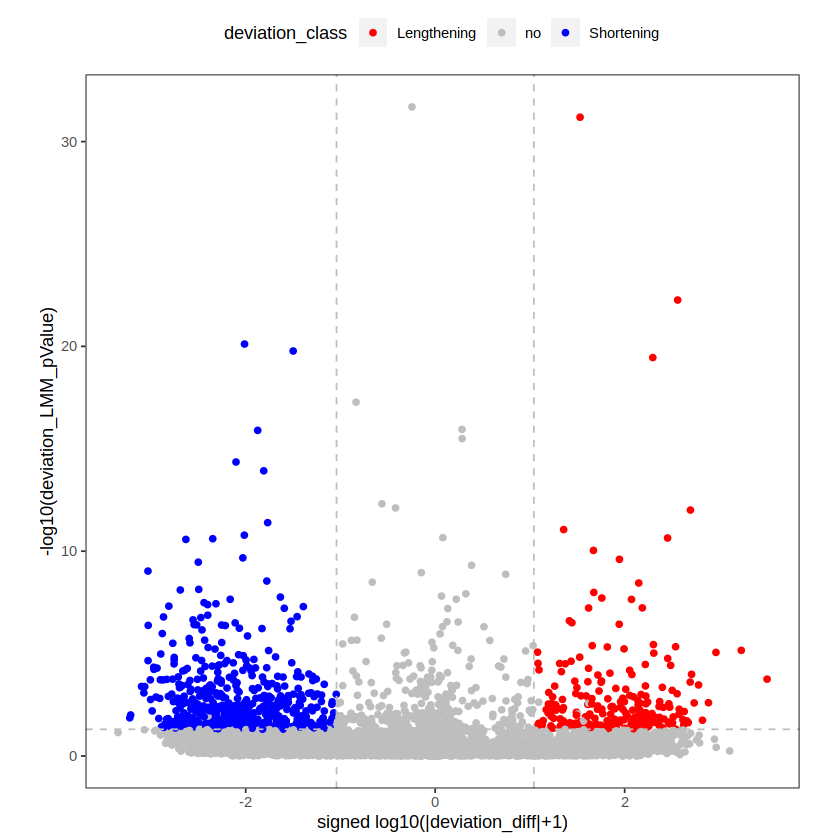

In [64]:
ggplot(
  df_dugs, # %>% filter(deviation_diff_fdr < 0.05, cor_fdr < 0.05, DEG_p_val < 0.05, fisher_pvalue < 0.05),
  aes(x = log10(abs(deviation_diff) + 1) * sign(deviation_diff), y = -log10(deviation_LMM_pValue), color = deviation_class)
) +
  geom_point() +
  mytheme +
  scale_color_manual(values = c("red", "gray", "blue")) +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = log10(10 + 1), linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = -log10(10 + 1), linetype = "dashed", color = "gray", size = 0.5) +
  # geom_label_repel(data=df_p %>% filter(deviation_diff_fdr < 0.05, cor_fdr < 0.05, DEG_p_val < 0.05, abs(deviation_diff) > 50), aes(label=GeneName, box.padding = 0.25))+
  labs(x = "signed log10(|deviation_diff|+1)", y = "-log10(deviation_LMM_pValue)") +
  theme(aspect.ratio = 1) +
  theme(legend.position = "top")
ggsave(filename = "1_differential_3UTR_deviation_Volcano.pdf", height = 3.7)

# GO

In [68]:
suppressMessages({
  options(stringsAsFactors = FALSE)
  library(DESeq2)
  library(clusterProfiler)
  library(enrichplot)
  library(tidyverse)
  library(org.Hs.eg.db)
  library(DOSE)
  library(pathview)
  library(msigdbr)
  library(dplyr)
  library(ggplot2)
  library(pheatmap)
  library(RColorBrewer)
  library(ggrepel)
  library(tidyverse)
})

In [69]:
table(df_dugs$deviation_class)


Lengthening          no  Shortening 
        220        4300         542 

In [ ]:
deg_up <- df_dugs %>% filter(deviation_class %in% c("Shortening")) # , GeneTPM_Deviation_Cor_pvalue < 0.05
dim(deg_up)
deg_down <- df_dugs %>% filter(deviation_class %in% c("Lengthening")) # , GeneTPM_Deviation_Cor_pvalue < 0.05
dim(deg_down)
gene_up_entrez <- unique(as.character(na.omit(bitr(deg_up$GeneName, fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL"), OrgDb = "org.Hs.eg.db")[, 2])))
length(gene_up_entrez)
gene_down_entrez <- unique(as.character(na.omit(bitr(deg_down$GeneName, fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL"), OrgDb = "org.Hs.eg.db")[, 2])))
length(gene_down_entrez)

In [109]:
for (regulated in c("Shortening")) { # ,'Lengthening'
  if (regulated == "Shortening") {
    gene_entrez <- gene_up_entrez
  } else {
    gene_entrez <- gene_down_entrez
  }

  print("GO analysis...")
  go <- enrichGO(gene = gene_entrez, OrgDb = "org.Hs.eg.db", ont = "BP", pvalueCutoff = 0.05, qvalueCutoff = 0.2, readable = TRUE)
  saveRDS(go, file = sprintf("2_GOenrich_%s.rds", regulated))
  write.table(as.data.frame(go), file = sprintf("2_GOenrich_FC2_%s.txt", regulated), quote = F, sep = "\t", row.names = F)

  enrichplot::dotplot(go, showCategory = 10) + theme(legend.key.size = unit(10, "pt"), plot.margin = unit(c(1, 1, 1, 1), "lines")) + theme(legend.position = "top")
  ggsave(sprintf("2_GOenrich_dotplot_%s.pdf", regulated), height = 4, width = 4)
}

[1] "GO analysis..."


## plot

In [72]:
getwd()

[1] "/gpfs1/tangfuchou_pkuhpc/tangfuchou_cls/luping/project/ont_iso_crc/2_RNA_CRC/01_RNA_analysis/CRC_HTCRC_06_RNA_UTR/CorrectUTR_CRC_HTCRC_02_UTR_deviation"

In [73]:
go <- readRDS("2_GOenrich_Shortening.rds")

In [74]:
go@result <- go@result %>%
  filter(!(Description %in% c("viral process", "viral life cycle", "viral genome replication")))

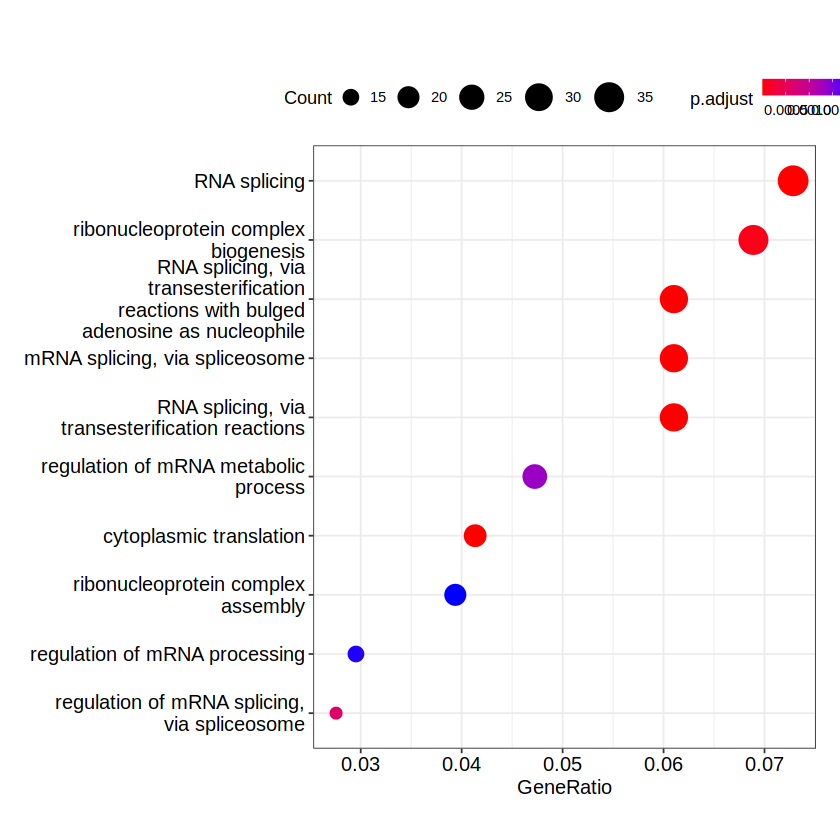

In [76]:
enrichplot::dotplot(go, showCategory = 10) + theme(legend.key.size = unit(10, "pt"), plot.margin = unit(c(1, 1, 1, 1), "lines")) +
  theme(legend.position = "top", aspect.ratio = 1.2)
ggsave(sprintf("2_GOenrich_dotplot_%s.pdf", "Shortening"), width = 8, height = 6)

# CPA

In [77]:
df_dugs <- read.table(file = "1_differential_3UTR_deviation_nofiltered.txt", header = T, sep = "\t") %>% filter(deviation_class %in% c("Shortening", "Lengthening"))
table(df_dugs$deviation_class)
dim(df_dugs)


Lengthening  Shortening 
        220         542 

[1] 762  31

In [78]:
anno_utr <- data.frame(
  row.names = df_dugs$GeneName,
  class = df_dugs$deviation_class
)
anno_utr <- anno_utr[order(anno_utr$class), , drop = F]

In [79]:
ont <- readRDS(file = "../../CRC_HTCRC_02_RNA_seurat/CRC_HTCRC_01_RNA_5400_3262_tx/00_tx_5400_3262_hvg1869_PC1_20.rds")
ont <- subset(ont, cells = ont@meta.data[which(ont@meta.data$celltype3 %in% c("Stem/TA", "Stem/TA-like")), ]$CellName)
ont

An object of class Seurat 
52636 features across 2679 samples within 4 assays 
Active assay: UTR5 (5310 features, 0 variable features)
 3 other assays present: RNA, GENE, UTR3
 3 dimensional reductions calculated: pca, tsne, umap

In [80]:
df1 <- as.data.frame(ont@assays$UTR3@counts[rownames(anno_utr), ])
head(df1, 1)

,CRC01_L1_Barcode01,CRC01_L1_Barcode08,CRC01_L1_Barcode09,CRC01_L1_Barcode10,CRC01_L1_Barcode17,CRC01_L1_Barcode21,CRC01_L1_Barcode22,CRC01_L1_Barcode30,CRC01_L1_Barcode33,CRC01_L1_Barcode34,⋯,HTCRC05_PT2_Bc96_Bc32,HTCRC05_PT2_Bc96_Bc35,HTCRC05_PT2_Bc96_Bc37,HTCRC05_PT2_Bc96_Bc38,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAMDC,-13.42812,-11.90985,NaN,-13.42812,NaN,NaN,-13.42812,-13.42812,-12.2045,NaN,⋯,-11.91731,NaN,NaN,NaN,-13.42812,NaN,NaN,NaN,NaN,NaN


In [81]:
cpa <- read.table(file = "../../marker/CPAregulators.txt", header = T, sep = "\t")
cpa <- cpa[which(cpa$GeneName %in% intersect(rownames(ont@assays$GENE@data), cpa$GeneName)), ]
# cpa

In [82]:
df2 <- as.data.frame(ont@assays$GENE@data[cpa$GeneName, ])
head(df2, 1)

,CRC01_L1_Barcode01,CRC01_L1_Barcode08,CRC01_L1_Barcode09,CRC01_L1_Barcode10,CRC01_L1_Barcode17,CRC01_L1_Barcode21,CRC01_L1_Barcode22,CRC01_L1_Barcode30,CRC01_L1_Barcode33,CRC01_L1_Barcode34,⋯,HTCRC05_PT2_Bc96_Bc32,HTCRC05_PT2_Bc96_Bc35,HTCRC05_PT2_Bc96_Bc37,HTCRC05_PT2_Bc96_Bc38,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CLP1,0,0,0,0,0,0,0,1.49856,0,0,⋯,0,0,0,2.032162,0,0,1.027643,0,0,0


In [83]:
anno_cpa <- data.frame(row.names = cpa$GeneName, cpa = cpa$CPAregulatorsClass)
anno_cpa$cpa <- factor(anno_cpa$cpa, levels = c(names(table(anno_cpa$cpa))))

In [84]:
df_cor <- cor(
  t(df2), t(df1),
  use = "pairwise.complete.obs", method = "spearman"
)

In [85]:
ann_col <- list(
  "class" = c(`Shortening` = "blue", `Lengthening` = "red")
)
ann_col[["cpa"]] <- c("#ff0301", "#fec000", "#fcff02", "#90d050", "#01b050", "#14b0f0", "#1570bf", "#072160", "#7030a0", "#757171")
names(ann_col[["cpa"]]) <- names(table(anno_cpa$cpa))

In [86]:
pheatmap(t(df_cor),
  scale = "none", annotation_col = anno_cpa, annotation_row = anno_utr, cluster_rows = T, show_colnames = T, show_rownames = F, border_color = "NA",
  color = colorRampPalette(rev(c("#67001f", "#b2182b", "#d6604d", "#f4a582", "#fddbc7", "#f7f7f7", "#d1e5f0", "#92c5de", "#4393c3", "#2166ac", "#053061")))(40),
  annotation_colors = ann_col,
  clustering_method = "ward.D2", breaks = seq(-0.3, 0.3, length.out = 40), file = "3_differential_3UTR_deviation_heatmap_CPA.pdf", height = 4, width = 8,
)

In [87]:
df_dugs <- read.table(file = "1_differential_3UTR_deviation_nofiltered.txt", header = T, sep = "\t") %>% filter(deviation_class %in% c("Shortening", "Lengthening"))
table(df_dugs$deviation_class)
dim(df_dugs)
# filter(GeneName %in% c('TMEM33','FASTKD2','CSDE1','ZFAND5','SERINC3','RANBP1','SUGT1','CD44','ARIH2','HNRNPK','CXADR','MAGT1','LAMP2'))


Lengthening  Shortening 
        220         542 

[1] 762  31

## Shortening

Saving 6.67 x 3.7 in image


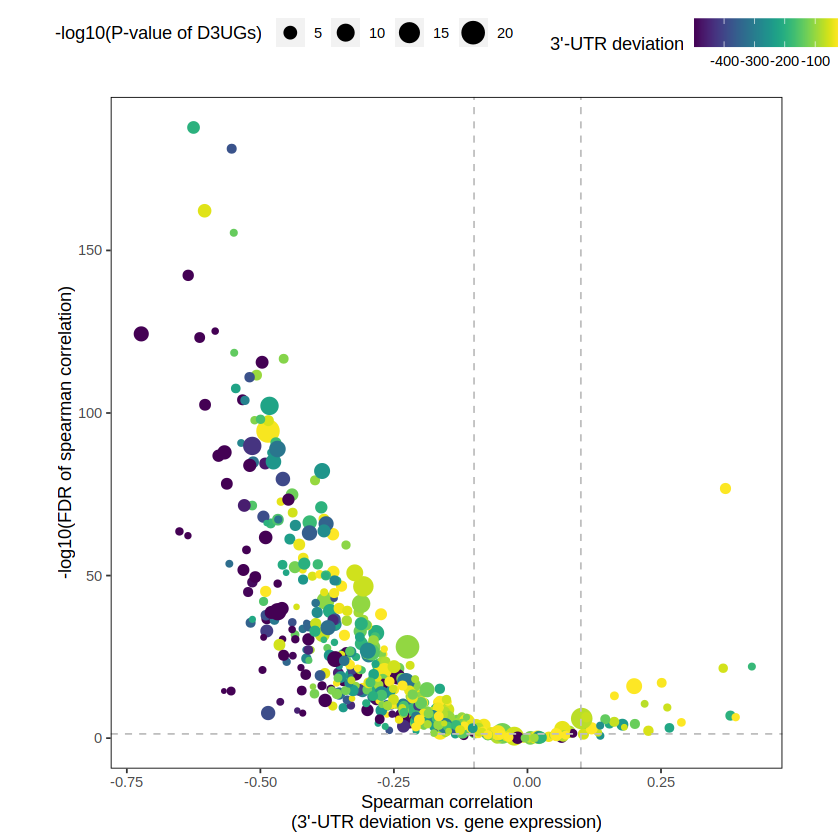

Saving 6.67 x 3.7 in image


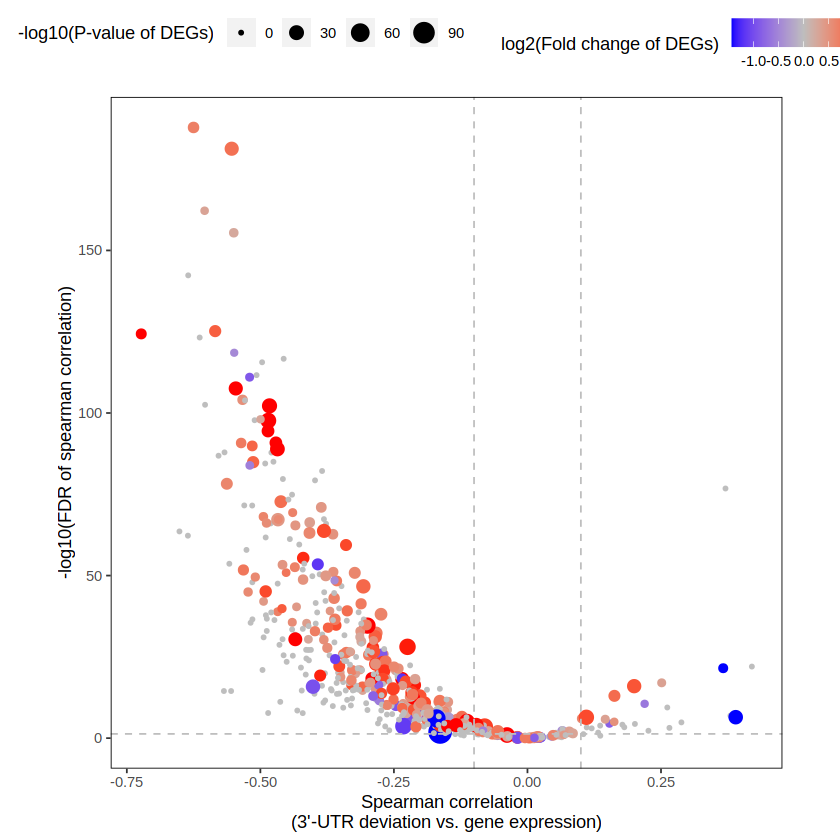

In [88]:
df_p <- df_dugs %>%
  filter(deviation_class %in% c("Shortening")) %>% # abs(deviation_diff) > 35
  mutate(
    deviation_diff = ifelse(
      deviation_diff < quantile(deviation_diff, 0.1, na.rm = TRUE),
      quantile(deviation_diff, 0.1, na.rm = TRUE), deviation_diff
    ),
    deviation_diff = ifelse(
      deviation_diff > quantile(deviation_diff, 0.9, na.rm = TRUE),
      quantile(deviation_diff, 0.9, na.rm = TRUE), deviation_diff
    )
  )
ggplot(
  df_p,
  aes(
    x = GeneTPM_Deviation_Cor, y = -log10(GeneTPM_Deviation_Cor_fdr),
    color = deviation_diff, size = -log10(deviation_LMM_pValue)
  )
) +
  geom_point() +
  scale_color_viridis() +
  mytheme +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = 0.1, linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = -0.1, linetype = "dashed", color = "gray", size = 0.5) +
  labs(
    x = "Spearman correlation\n(3'-UTR deviation vs. gene expression)",
    y = "-log10(FDR of spearman correlation)", color = "3'-UTR deviation",
    size = "-log10(P-value of D3UGs)"
  ) +
  theme(aspect.ratio = 1, legend.position = "top")
ggsave(filename = "4_Volcano_ShortenGene_cor_deviation_and_expression_1.pdf", height = 3.7)


df_p[which(df_p$DEG_cluster %in% "Stem/TA"), ]$DEG_avg_log2FC <- -df_p[which(df_p$DEG_cluster %in% "Stem/TA"), ]$DEG_avg_log2FC
df_p[which(df_p$DEG_avg_log2FC > log2(2.7)), ]$DEG_avg_log2FC <- log2(2.7)
df_p[which(df_p$DEG_avg_log2FC < -log2(2.7)), ]$DEG_avg_log2FC <- -log2(2.7)
df_p[is.na(df_p$DEG_avg_log2FC), ]$DEG_avg_log2FC <- 0
df_p[is.na(df_p$DEG_p_val), ]$DEG_p_val <- 1

ggplot(
  df_p,
  aes(x = GeneTPM_Deviation_Cor, y = -log10(GeneTPM_Deviation_Cor_fdr), color = DEG_avg_log2FC, size = -log10(DEG_p_val))
) +
  geom_point() +
  scale_color_gradient2(low = "blue", mid = "gray", high = "red") +
  mytheme +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = 0.1, linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = -0.1, linetype = "dashed", color = "gray", size = 0.5) +
  labs(
    x = "Spearman correlation\n(3'-UTR deviation vs. gene expression)",
    y = "-log10(FDR of spearman correlation)", color = "log2(Fold change of DEGs)",
    size = "-log10(P-value of DEGs)"
  ) +
  theme(aspect.ratio = 1, legend.position = "top")
ggsave(filename = "4_Volcano_ShortenGene_cor_deviation_and_expression_2.pdf", height = 3.7)

## Lengthening

Saving 6.67 x 3.7 in image


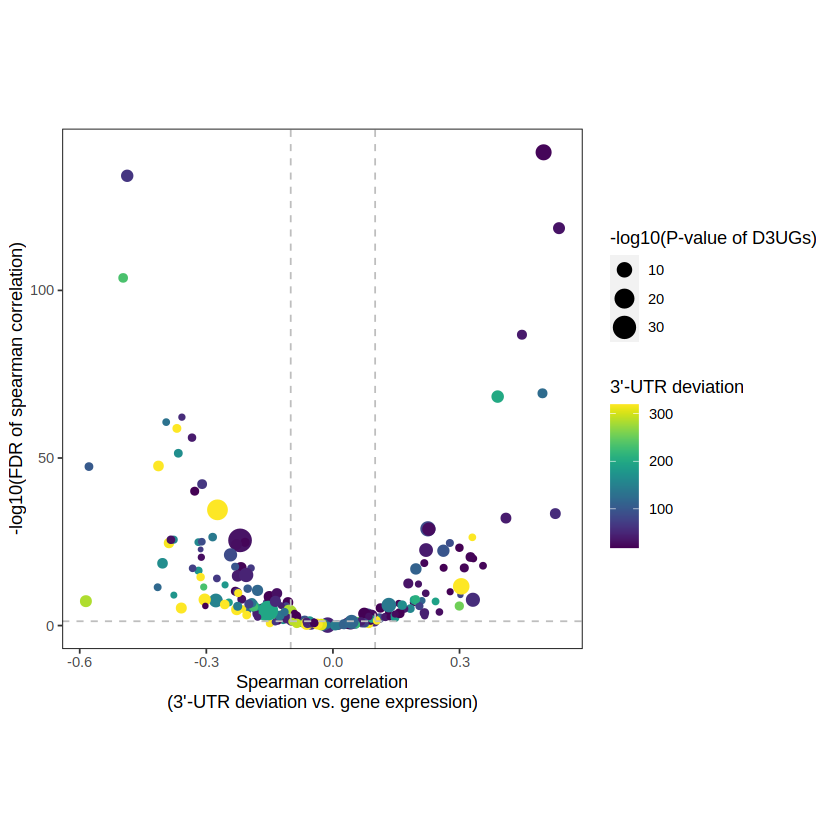

Saving 6.67 x 3.7 in image


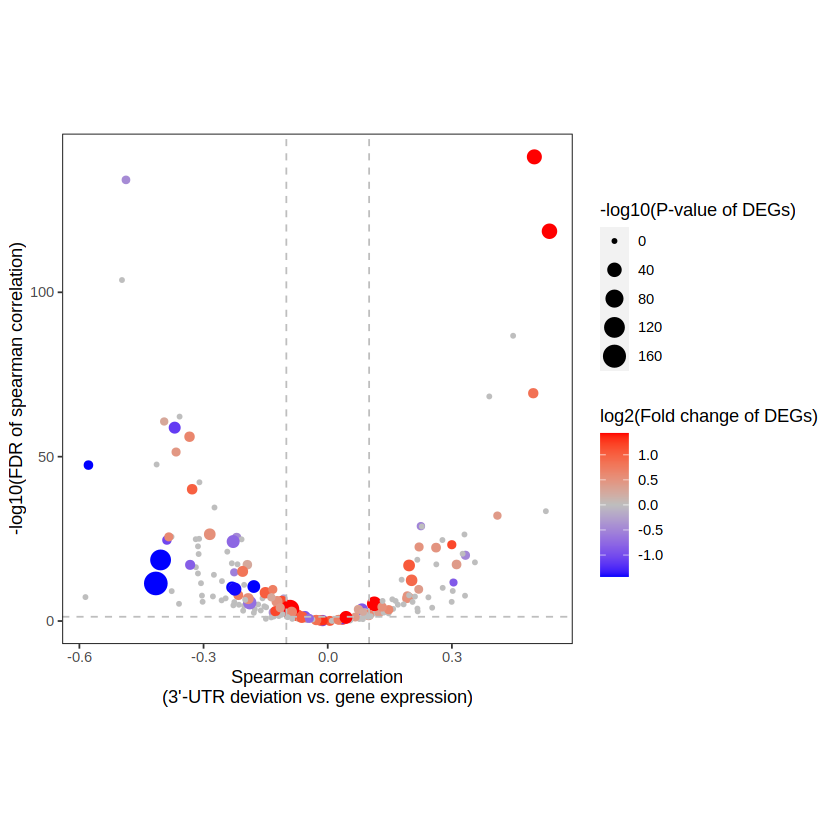

In [89]:
df_p <- df_dugs %>%
  filter(deviation_class %in% c("Lengthening")) %>%
  mutate(deviation_diff = ifelse(
    deviation_diff < quantile(deviation_diff, 0.1, na.rm = TRUE),
    quantile(deviation_diff, 0.1, na.rm = TRUE), deviation_diff
  ), deviation_diff = ifelse(
    deviation_diff > quantile(deviation_diff, 0.9, na.rm = TRUE),
    quantile(deviation_diff, 0.9, na.rm = TRUE), deviation_diff
  ))
ggplot(
  df_p,
  aes(x = GeneTPM_Deviation_Cor, y = -log10(GeneTPM_Deviation_Cor_fdr), color = deviation_diff, size = -log10(deviation_LMM_pValue))
) +
  geom_point() +
  scale_color_viridis() +
  mytheme +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = 0.1, linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = -0.1, linetype = "dashed", color = "gray", size = 0.5) +
  labs(
    x = "Spearman correlation\n(3'-UTR deviation vs. gene expression)",
    y = "-log10(FDR of spearman correlation)",
    color = "3'-UTR deviation",
    size = "-log10(P-value of D3UGs)"
  ) +
  theme(aspect.ratio = 1)
ggsave(filename = "4_Volcano_LengthenGene_cor_deviation_and_expression_1.pdf", height = 3.7)


df_p[which(df_p$DEG_cluster %in% "Stem/TA"), ]$DEG_avg_log2FC <- -df_p[which(df_p$DEG_cluster %in% "Stem/TA"), ]$DEG_avg_log2FC
df_p[which(df_p$DEG_avg_log2FC > log2(2.7)), ]$DEG_avg_log2FC <- log2(2.7)
df_p[which(df_p$DEG_avg_log2FC < -log2(2.7)), ]$DEG_avg_log2FC <- -log2(2.7)
df_p[is.na(df_p$DEG_avg_log2FC), ]$DEG_avg_log2FC <- 0
df_p[is.na(df_p$DEG_p_val), ]$DEG_p_val <- 1

ggplot(
  df_p,
  aes(x = GeneTPM_Deviation_Cor, y = -log10(GeneTPM_Deviation_Cor_fdr), color = DEG_avg_log2FC, size = -log10(DEG_p_val))
) +
  geom_point() +
  scale_color_gradient2(low = "blue", mid = "gray", high = "red") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = 0.1, linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = -0.1, linetype = "dashed", color = "gray", size = 0.5) +
  labs(
    x = "Spearman correlation\n(3'-UTR deviation vs. gene expression)",
    y = "-log10(FDR of spearman correlation)",
    color = "log2(Fold change of DEGs)",
    size = "-log10(P-value of DEGs)"
  ) +
  mytheme
theme(aspect.ratio = 1)
ggsave(filename = "4_Volcano_LengthenGene_cor_deviation_and_expression_2.pdf", height = 3.7)

## Select candidates and labeling

In [90]:
df_dugs <- read.table(file = "1_differential_3UTR_deviation_nofiltered.txt", header = T, sep = "\t") %>% filter(deviation_class %in% c("Shortening", "Lengthening"))
table(df_dugs$deviation_class)
dim(df_dugs)
# filter(GeneName %in% c('TMEM33','FASTKD2','CSDE1','ZFAND5','SERINC3','RANBP1','SUGT1','CD44','ARIH2','HNRNPK','CXADR','MAGT1','LAMP2'))


Lengthening  Shortening 
        220         542 

[1] 762  31

In [91]:
df_p <- df_dugs %>% filter(deviation_class %in% c("Shortening"))

In [92]:
micro <- read.table(file = "/gpfs1/tangfuchou_pkuhpc/tangfuchou_cls/luping/project/ont_iso_crc/2_RNA_CRC/0_smk_scanseq/resources/microRNA_binding_sites/TargetScan/Predicted_Target_Locations.default_predictions.hg38.bed", header = F, sep = "\t")
micro <- data.frame(
  GeneName = sapply(strsplit(micro$V4, split = ":"), function(x) {
    x[1]
  }), microRNA = micro$V4 # , microRNA_chr = micro$V1, microRNA_start = micro$V2, microRNA_end = micro$V3
) %>%
  filter(GeneName %in% df_p$GeneName) %>%
  group_by(GeneName) %>%
  summarise(microRNA = paste(microRNA, collapse = "; "))
dim(micro)
head(micro, 2)

[1] 413   2

GeneName,microRNA
<chr>,<chr>
ABCB8,ABCB8:miR-193-3p; ABCB8:miR-670-3p; ABCB8:miR-338-3p; ABCB8:miR-665; ABCB8:miR-3064-5p; ABCB8:miR-129-3p; ABCB8:miR-193-3p; ABCB8:miR-296-5p; ABCB8:miR-28-5p/708-5p
ABI2,ABI2:miR-7-5p; ABI2:miR-1298-5p; ABI2:miR-205-5p; ABI2:miR-362-5p/500b-5p; ABI2:miR-200bc-3p/429; ABI2:miR-655-3p; ABI2:miR-375; ABI2:miR-144-3p; ABI2:miR-101-3p.1; ABI2:miR-101-3p.2; ABI2:miR-101-3p.2; ABI2:miR-582-5p; ABI2:miR-302-3p/372-3p/373-3p/520-3p; ABI2:miR-494-3p; ABI2:miR-15-5p/16-5p/195-5p/424-5p/497-5p; ABI2:miR-103-3p/107; ABI2:miR-455-3p.2; ABI2:miR-15-5p/16-5p/195-5p/424-5p/497-5p; ABI2:miR-1-3p/206; ABI2:miR-24-3p; ABI2:miR-876-5p; ABI2:miR-323-3p; ABI2:miR-183-5p.2; ABI2:miR-216b-5p; ABI2:miR-193-3p; ABI2:miR-326; ABI2:miR-193-3p; ABI2:miR-183-5p.1; ABI2:miR-1193; ABI2:miR-135-5p; ABI2:miR-802; ABI2:miR-223-3p; ABI2:miR-375; ABI2:miR-19-3p; ABI2:miR-219-5p; ABI2:miR-125-5p; ABI2:miR-455-5p; ABI2:miR-501-3p/502-3p; ABI2:miR-330-3p.2; ABI2:miR-25-3p/32-5p/92-3p/363-3p/367-3p; ABI2:miR-452-5p/892-3p; ABI2:miR-218-5p; ABI2:miR-493-5p; ABI2:miR-1-3p/206; ABI2:miR-96-5p/1271-5p; ABI2:miR-33-5p; ABI2:miR-376-3p; ABI2:miR-873-5p.1; ABI2:miR-142-3p.1; ABI2:miR-196-5p; ABI2:miR-1197; ABI2:miR-421; ABI2:miR-142-3p.2; ABI2:miR-150-5p; ABI2:miR-1306-5p; ABI2:miR-150-5p; ABI2:miR-532-3p; ABI2:miR-338-3p; ABI2:miR-26-5p; ABI2:miR-134-5p; ABI2:miR-342-3p; ABI2:miR-378-3p; ABI2:miR-33-5p; ABI2:miR-186-5p; ABI2:miR-145-5p; ABI2:miR-409-3p; ABI2:miR-338-3p; ABI2:miR-7-5p; ABI2:miR-1197


In [93]:
marker <- read.csv(file = "../../marker/CRC_import_geneset_V1.csv", header = T)
utr3_example <- merge(df_p, marker, by = "GeneName", all.x = T)
utr3_example <- merge(micro, utr3_example, by = "GeneName", all.x = T)
utr3_example <- utr3_example[order(utr3_example$GeneTPM_Deviation_Cor, -utr3_example$DEG_avg_log2FC), ]
dim(utr3_example)

[1] 413  47

In [94]:
write.table(utr3_example, file = "5_utr3_example.txt", quote = F, row.names = F, sep = "\t")

In [95]:
test <- utr3_example %>%
  filter(
    deviation_class %in% "Shortening", GeneTPM_Deviation_Cor < -0.2, GeneTPM_Deviation_Cor_fdr < 0.05,
    deviation_LMM_pValue < 0.05, gene_tpm_CC > 30, DEG_cluster %in% "Stem/TA-like", deviation_diff_wilcox_fdr < 0.05 # , fisher_pvalue < 0.05,
  ) %>%
  dplyr::select(
    c(
      "GeneName", "deviation_class", "GeneTPM_Deviation_Cor", "GeneTPM_Deviation_Cor_fdr", "deviation_LMM_pValue", "fisher_pvalue", "gene_tpm_CC",
      "deviation_diff", "deviation_diff_wilcox_pvalue", "deviation_diff_wilcox_fdr",
      "SF", "TF", "RPB"
    )
  ) %>%
  arrange(GeneTPM_Deviation_Cor_fdr)
dim(test)
test <- test$GeneName
# test %>% arrange(GeneName)

[1] 50 13

### Alluvial

In [99]:
library(ggplot2)
library(ggalluvial)

for (i in c(1:length(test))) {
  mygene <- test[i]
  mytx <- unique(utr3[which(utr3$GeneName %in% mygene), ]$TranName)

  df <- data.frame(
    isoform = c(mytx, mytx),
    celltype = c(rep("Stem/TA", length(mytx)), rep("Stem/TA-like", length(mytx))),
    tpm = c(rowMeans(df_tpm[mytx, ne_cells]), rowMeans(df_tpm[mytx, cc_cells]))
  ) %>%
    group_by(celltype) %>%
    mutate(pct = tpm / sum(tpm))

  df$celltype <- factor(df$celltype, levels = c("Stem/TA", "Stem/TA-like"))
  write.table(df, file = sprintf("example_3/%s_%s_iso_alluvial.txt", i, mygene), sep = "\t", quote = F, row.names = F)

  ggplot(
    data = df, # %>% filter(isoform %in% c('CSDE1-202','CSDE1-204')),
    aes(x = celltype, y = tpm, alluvium = isoform, stratum = isoform, fill = isoform)
  ) +
    geom_alluvium(alpha = .5, decreasing = FALSE) +
    geom_stratum(decreasing = FALSE) +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), decreasing = FALSE) +
    mytheme +
    theme(panel.grid.major = element_line(colour = "#f0f0f0", linetype = "dashed"))
  ggsave(sprintf("example_3/%s_%s_iso_alluvial.pdf", i, mygene), height = 4, width = 6)
}

#### Candidates


In [100]:
# c('SF3B1','TMEM59','RCA1','ARIH2','CSDE1','PCBP2','EIF4G1','HNRNPK','NET1','PPP1CB','RCN2','CYB5B','SRSF4','SMAGP')

In [101]:
mylabel <- c(
  "CSDE1", "ARIH2", "HNRNPK", # 这次和上次都能筛出来
  "SF3B1", "TMEM59", "RAC1", "PCBP2", "EIF4G1", "NET1", "PPP1CB", "RCN2", "CYB5B", "SRSF4", "SMAGP", # 这次筛出来
  "CD44", "CXADR", "PEX2", "LSM5", "FASTKD2", "LAMP2"
) # 上次筛出来，这次结果也还凑合
length(mylabel)

[1] 20

### Labeling

Saving 6.67 x 4.4 in image


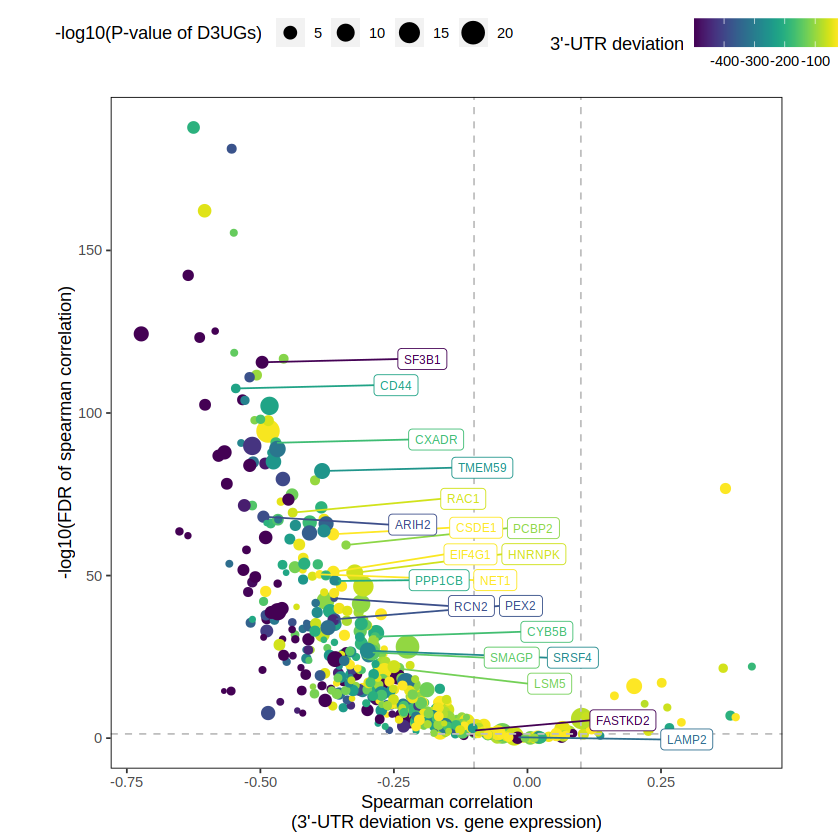

In [102]:
df_p <- df_dugs %>%
  filter(deviation_class %in% c("Shortening")) %>% # abs(deviation_diff) > 35
  mutate(
    deviation_diff = ifelse(
      deviation_diff < quantile(deviation_diff, 0.1, na.rm = TRUE), quantile(deviation_diff, 0.1, na.rm = TRUE), deviation_diff
    ),
    deviation_diff = ifelse(deviation_diff > quantile(deviation_diff, 0.9, na.rm = TRUE), quantile(deviation_diff, 0.9, na.rm = TRUE), deviation_diff)
  )
ggplot(
  df_p,
  aes(x = GeneTPM_Deviation_Cor, y = -log10(GeneTPM_Deviation_Cor_fdr), color = deviation_diff, size = -log10(deviation_LMM_pValue))
) +
  geom_point() +
  mytheme +
  scale_color_viridis() +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = 0.1, linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = -0.1, linetype = "dashed", color = "gray", size = 0.5) +
  labs(x = "Spearman correlation\n(3'-UTR deviation vs. gene expression)", y = "-log10(FDR of spearman correlation)", color = "3'-UTR deviation", size = "-log10(P-value of D3UGs)") +
  theme(aspect.ratio = 1) +
  theme(legend.position = "top") +
  geom_label_repel(
    data = df_p %>% filter(GeneName %in% mylabel), aes(x = GeneTPM_Deviation_Cor, y = -log10(GeneTPM_Deviation_Cor_fdr), label = GeneName),
    min.segment.length = unit(0, "lines"), nudge_x = 0.3, nudge_y = 1, size = 2.5, box.padding = 0.1, max.overlaps = 20 # Increase this value
  )
ggsave(filename = "5_Volcano_ShortenGene_cor_deviation_and_expression_1_label.pdf", height = 4.4)

Saving 6.67 x 4.4 in image


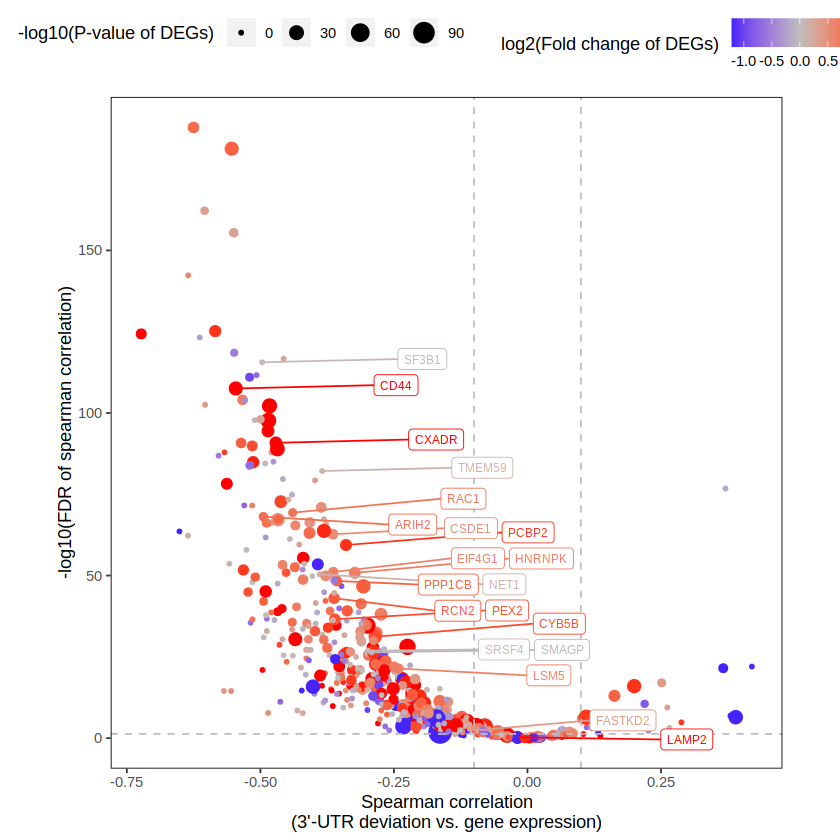

In [103]:
mymax <- quantile(df_p[which(df_p$gene_tpm_log2FoldChange > 0), ]$gene_tpm_log2FoldChange, 0.85, na.rm = TRUE)
mymin <- quantile(df_p[which(df_p$gene_tpm_log2FoldChange < 0), ]$gene_tpm_log2FoldChange, 0.15, na.rm = TRUE)

df_p[which(df_p$gene_tpm_log2FoldChange > mymax), ]$gene_tpm_log2FoldChange <- mymax
df_p[which(df_p$gene_tpm_log2FoldChange < mymin), ]$gene_tpm_log2FoldChange <- mymin
# df_p[is.na(df_p$gene_tpm_log2FoldChange),]$gene_tpm_log2FoldChange <- 0
df_p[is.na(df_p$DEG_p_val), ]$DEG_p_val <- 1

ggplot(
  df_p,
  aes(x = GeneTPM_Deviation_Cor, y = -log10(GeneTPM_Deviation_Cor_fdr), color = gene_tpm_log2FoldChange, size = -log10(DEG_p_val))
) +
  geom_point() +
  mytheme +
  scale_color_gradient2(low = "blue", mid = "gray", high = "red") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = 0.1, linetype = "dashed", color = "gray", size = 0.5) +
  geom_vline(xintercept = -0.1, linetype = "dashed", color = "gray", size = 0.5) +
  labs(x = "Spearman correlation\n(3'-UTR deviation vs. gene expression)", y = "-log10(FDR of spearman correlation)", color = "log2(Fold change of DEGs)", size = "-log10(P-value of DEGs)") +
  theme(aspect.ratio = 1) +
  theme(legend.position = "top") +
  geom_label_repel(
    data = df_p %>% filter(GeneName %in% mylabel), aes(x = GeneTPM_Deviation_Cor, y = -log10(GeneTPM_Deviation_Cor_fdr), label = GeneName),
    min.segment.length = unit(0, "lines"), nudge_x = 0.3, nudge_y = 1, size = 2.5, box.padding = 0.1, max.overlaps = 20 # Increase this value
  )
ggsave(filename = "5_Volcano_ShortenGene_cor_deviation_and_expression_2_label.pdf", height = 4.4)

#### Example

In [105]:
library(ggplot2)
library(ggalluvial)

In [106]:
utr <- read.table(file = "../CRC_HTCRC_01_UTR_length/UTR_info.txt", header = F, sep = "\t")
colnames(utr) <- c("chrom", "utr", "start", "end", "strand", "TranName", "GeneName")
utr$length <- abs(utr$end - utr$start)
utr$utr_coor <- paste(utr$start, utr$end, sep = "_")

utr3 <- utr %>%
  filter(utr %in% "three_prime_utr") %>%
  group_by(TranName) %>%
  mutate(UTR3ID = paste(GeneName, chrom, paste(utr_coor, collapse = "__"), sep = "-"), UTR3_length = sum(length)) %>%
  dplyr::select(TranName, UTR3ID, GeneName, UTR3_length) %>%
  as.data.frame() %>%
  filter(!duplicated(TranName)) %>%
  `rownames<-`(.$TranName) %>%
  arrange(TranName) %>%
  group_by(GeneName) %>%
  mutate(UTR3_number = length(unique(UTR3ID))) %>%
  as.data.frame()
dim(utr3)
head(utr3, 2)

[1] 19757     5

,TranName,UTR3ID,GeneName,UTR3_length,UTR3_number
,<chr>,<chr>,<chr>,<int>,<int>
1,A1CF-202,A1CF-10-50806562_50806728,A1CF,166,2
2,A1CF-204,A1CF-10-50799409_50806728,A1CF,7319,2


In [53]:
df_tpm <- read.csv(file = "../../CRC_HTCRC_01_RNA_QC/00_tx_tpm_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)

In [198]:
ont <- readRDS(file = "../../CRC_HTCRC_02_RNA_seurat/CRC_HTCRC_01_RNA_5400_3262_tx/00_tx_5400_3262_hvg1869_PC1_20.rds")
ne_cells <- ont@meta.data[which(ont@meta.data$celltype3 %in% "Stem/TA"), ]$CellName
length(ne_cells)
cc_cells <- ont@meta.data[which(ont@meta.data$celltype3 %in% "Stem/TA-like"), ]$CellName
length(cc_cells)

[1] 359

[1] 2320

In [199]:
ont_sub <- subset(ont, cells = c(ne_cells, cc_cells))
ont_sub

An object of class Seurat 
51718 features across 2679 samples within 4 assays 
Active assay: UTR3 (4609 features, 0 variable features)
 3 other assays present: RNA, GENE, UTR5
 3 dimensional reductions calculated: pca, tsne, umap

Saving 6.67 x 2 in image


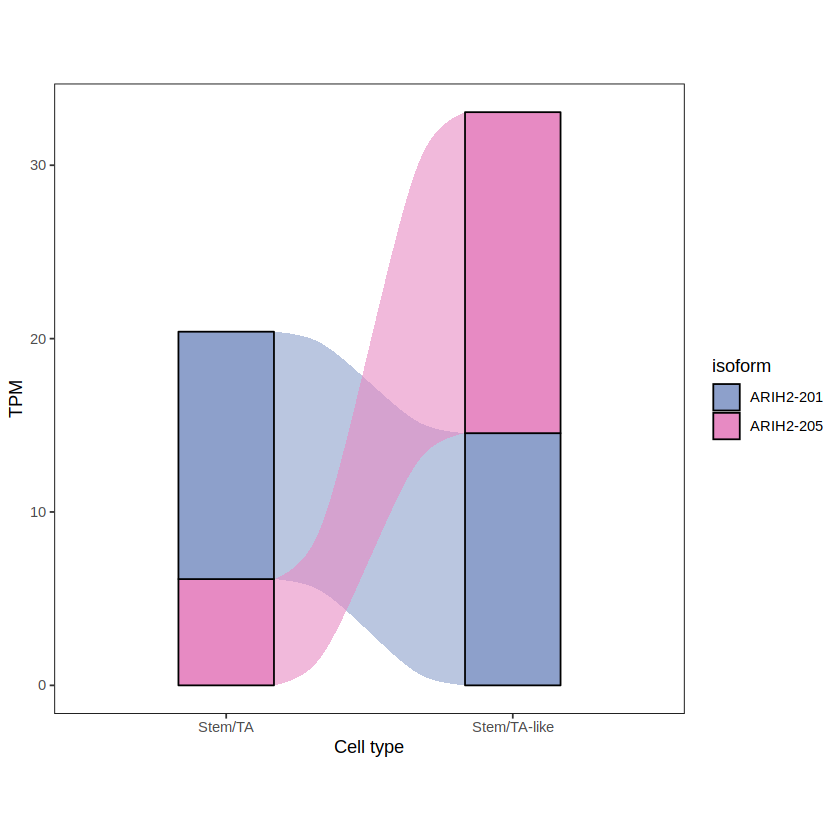

In [218]:
mygene <- "ARIH2"
mytx <- unique(utr3[which(utr3$GeneName %in% mygene), ]$TranName)

df <- data.frame(
  isoform = c(mytx, mytx),
  celltype = c(rep("Stem/TA", length(mytx)), rep("Stem/TA-like", length(mytx))),
  tpm = c(rowMeans(df_tpm[mytx, ne_cells]), rowMeans(df_tpm[mytx, cc_cells]))
) %>%
  group_by(celltype) %>%
  mutate(pct = tpm / sum(tpm))

df$celltype <- factor(df$celltype, levels = c("Stem/TA", "Stem/TA-like"))
write.table(df, file = sprintf("final_example/%s_iso_alluvial.txt", mygene), sep = "\t", quote = F, row.names = F)

custom_colors <- c("#8da0cb", "#e78ac3")
ggplot(
  data = df,
  aes(x = celltype, y = tpm, alluvium = isoform, stratum = isoform, fill = isoform)
) +
  geom_alluvium(alpha = .6, decreasing = FALSE) +
  geom_stratum(decreasing = FALSE) +
  scale_fill_manual(values = custom_colors) +
  mytheme +
  labs(x = "Cell type", y = "TPM") +
  theme(aspect.ratio = 1)
ggsave(file = sprintf("final_example/%s_iso_alluvial.pdf", mygene), height = 2)

Saving 6.67 x 2 in image


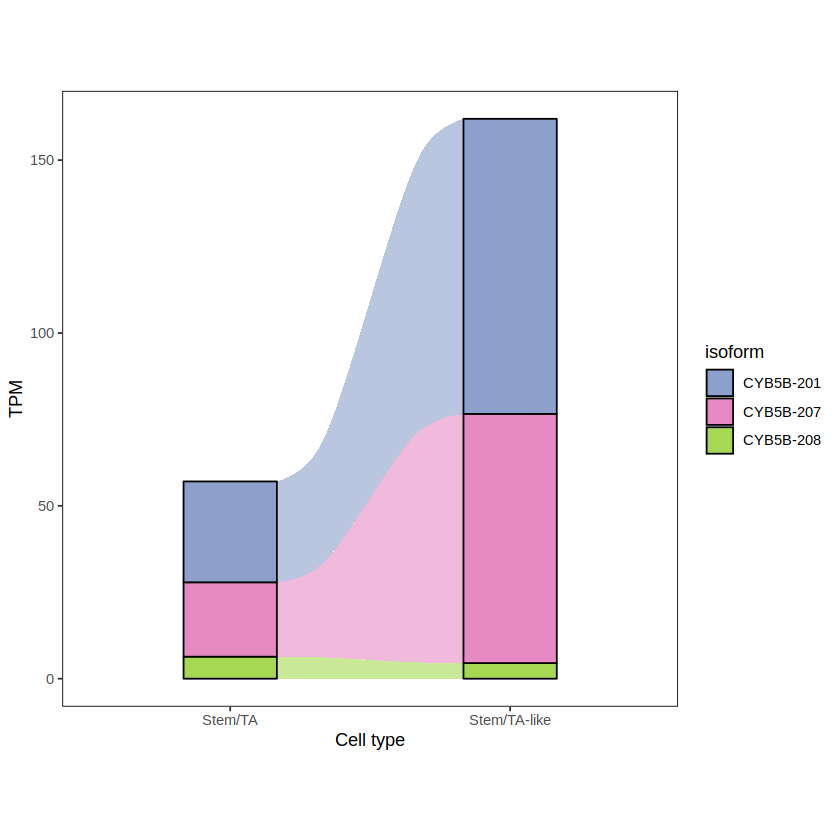

In [217]:
mygene <- "CYB5B"
mytx <- unique(utr3[which(utr3$GeneName %in% mygene), ]$TranName)

df <- data.frame(
  isoform = c(mytx, mytx),
  celltype = c(rep("Stem/TA", length(mytx)), rep("Stem/TA-like", length(mytx))),
  tpm = c(rowMeans(df_tpm[mytx, ne_cells]), rowMeans(df_tpm[mytx, cc_cells]))
) %>%
  group_by(celltype) %>%
  mutate(pct = tpm / sum(tpm))

df$celltype <- factor(df$celltype, levels = c("Stem/TA", "Stem/TA-like"))
write.table(df, file = sprintf("final_example/%s_iso_alluvial.txt", mygene), sep = "\t", quote = F, row.names = F)

custom_colors <- c(
  "#8da0cb",
  "#e78ac3",
  "#a6d854"
)
ggplot(
  data = df,
  aes(x = celltype, y = tpm, alluvium = isoform, stratum = isoform, fill = isoform)
) +
  geom_alluvium(alpha = .6, decreasing = FALSE) +
  geom_stratum(decreasing = FALSE) +
  scale_fill_manual(values = custom_colors) +
  mytheme +
  labs(x = "Cell type", y = "TPM") +
  theme(aspect.ratio = 1)
ggsave(file = sprintf("final_example/%s_iso_alluvial.pdf", mygene), height = 2)

Saving 6.67 x 2 in image


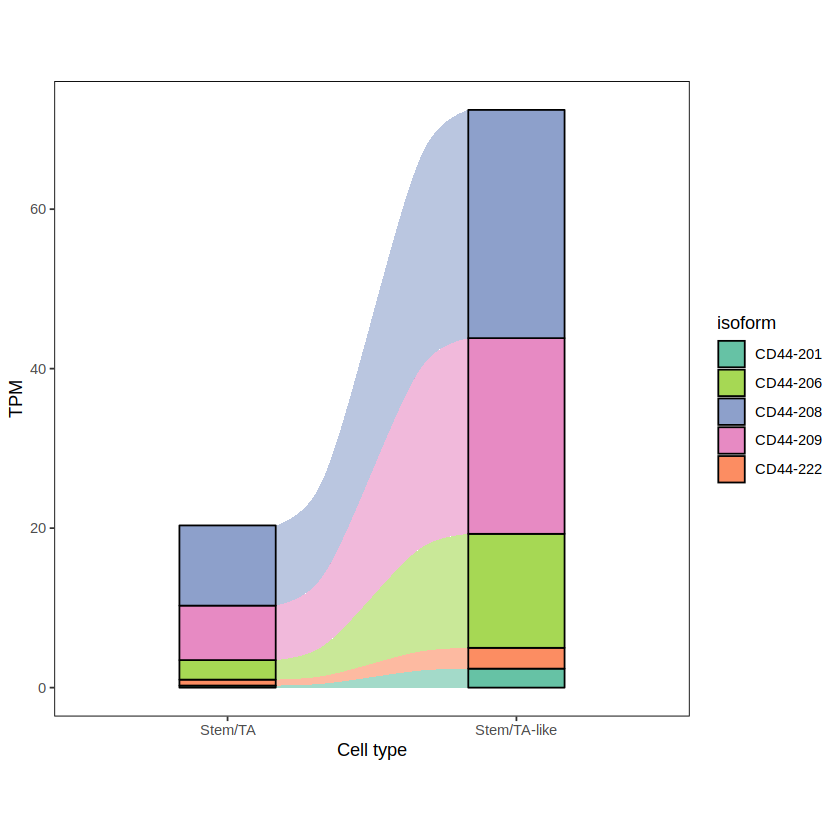

In [ ]:
mygene <- "CD44"
mytx <- unique(utr3[which(utr3$GeneName %in% mygene), ]$TranName)

df <- data.frame(
  isoform = c(mytx, mytx),
  celltype = c(rep("Stem/TA", length(mytx)), rep("Stem/TA-like", length(mytx))),
  tpm = c(rowMeans(df_tpm[mytx, ne_cells]), rowMeans(df_tpm[mytx, cc_cells]))
) %>%
  group_by(celltype) %>%
  mutate(pct = tpm / sum(tpm))

df$celltype <- factor(df$celltype, levels = c("Stem/TA", "Stem/TA-like"))
write.table(df, file = sprintf("final_example/%s_iso_alluvial.txt", mygene), sep = "\t", quote = F, row.names = F)

custom_colors <- c(
  "#66c2a5", "#a6d854", "#8da0cb", "#e78ac3", "#fc8d62"
)
ggplot(
  data = df,
  aes(x = celltype, y = tpm, alluvium = isoform, stratum = isoform, fill = isoform)
) +
  geom_alluvium(alpha = .6, decreasing = FALSE) +
  geom_stratum(decreasing = FALSE) +
  scale_fill_manual(values = custom_colors) +
  mytheme +
  labs(x = "Cell type", y = "TPM") +
  theme(aspect.ratio = 1)
ggsave(file = sprintf("final_example/%s_iso_alluvial.pdf", mygene), height = 2)